Heart Rate (BPM): 60.52
HRV (SDNN): 0.2758


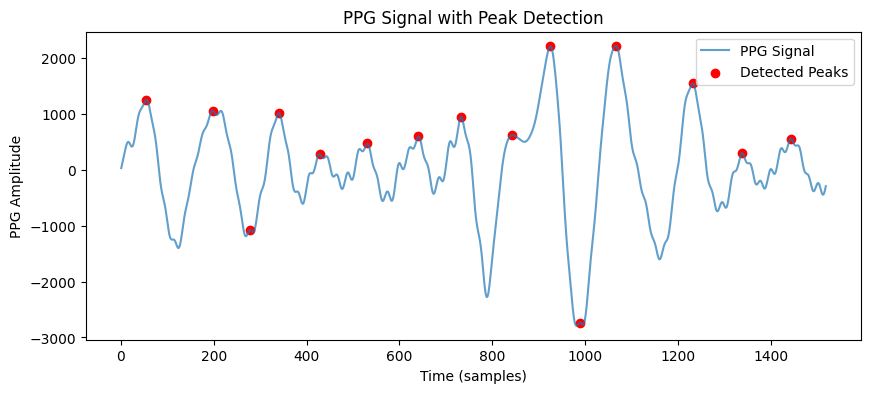

In [ ]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt

def load_ppg(filename):
    """Load PPG waveform data from CSV."""
    df = pd.read_csv(filename)
    return df["green"].values, df["sample_index"].values  # Using green PPG signal

def butter_bandpass_filter(data, lowcut=0.5, highcut=3.0, fs=100, order=2):
    """Apply a Butterworth Bandpass Filter to remove noise."""
    nyquist = 2 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

def detect_peaks(ppg_signal, fs=100):
    """Detect peaks in the PPG signal to calculate HR & HRV."""
    peaks, _ = signal.find_peaks(ppg_signal, distance=fs*0.6)  # Assuming HR > 40 BPM
    rr_intervals = np.diff(peaks) / fs  # Convert to seconds
    heart_rate = 60 / rr_intervals.mean()  # BPM
    hrv = np.std(rr_intervals)  # Standard deviation of RR intervals
    return heart_rate, hrv, peaks

def plot_ppg(ppg_signal, peaks, sample_index):
    """Plot PPG waveform with detected peaks."""
    plt.figure(figsize=(10, 4))
    plt.plot(sample_index, ppg_signal, label="PPG Signal", alpha=0.7)
    plt.scatter(sample_index[peaks], ppg_signal[peaks], color='red', label="Detected Peaks")
    plt.xlabel("Time (samples)")
    plt.ylabel("PPG Amplitude")
    plt.legend()
    plt.title("PPG Signal with Peak Detection")
    plt.show()

# Example usage (replace with actual file path)
filename = "/content/regular_1.csv"
ppg_signal, sample_index = load_ppg(filename)
filtered_signal = butter_bandpass_filter(ppg_signal)
heart_rate, hrv, peaks = detect_peaks(filtered_signal)

print(f"Heart Rate (BPM): {heart_rate:.2f}")
print(f"HRV (SDNN): {hrv:.4f}")
plot_ppg(filtered_signal, peaks, sample_index)

We'll compute oxygen saturation (SpO₂) using the Ratio of Ratios (RoR) method:

𝑆
𝑝
𝑂
2
=
𝐴
−
𝐵
×
(
𝐴
𝐶
𝑟
𝑒
𝑑
/
𝐷
𝐶
𝑟
𝑒
𝑑
)
(
𝐴
𝐶
𝐼
𝑅
/
𝐷
𝐶
𝐼
𝑅
)
SpO
2
​
 =A−B×
(AC
IR
​
 /DC
IR
​
 )
(AC
red
​
 /DC
red
​
 )
​

where:

AC = Peak-to-Peak Amplitude (high-frequency component).
DC = Mean Value (baseline signal).
Constants A ≈ 110, B ≈ 25 (empirical values from literature).

In [ ]:
def calculate_spo2(red_signal, ir_signal):
    """Compute SpO₂ using Red & IR signals (Ratio of Ratios method)."""
    ac_red = np.ptp(red_signal)  # Peak-to-Peak Amplitude of Red
    ac_ir = np.ptp(ir_signal)    # Peak-to-Peak Amplitude of IR
    dc_red = np.mean(red_signal) # DC Component (Mean) of Red
    dc_ir = np.mean(ir_signal)   # DC Component (Mean) of IR

    r_value = (ac_red / dc_red) / (ac_ir / dc_ir)
    spo2 = 110 - 25 * r_value  # Empirical formula

    return max(70, min(spo2, 100))  # Clamp values between 70-100%

# Example usage
red_signal = np.random.normal(500, 50, 1000)  # Replace with actual PPG data
ir_signal = np.random.normal(600, 50, 1000)   # Replace with actual PPG data
spo2_value = calculate_spo2(red_signal, ir_signal)
print(f"Estimated SpO₂: {spo2_value:.2f}%")

Estimated SpO₂: 79.81%


In [ ]:
def remove_motion_artifacts(ppg_signal, acc_x, acc_y, acc_z, fs=100):
    """Reduce motion artifacts using accelerometer data."""
    acc_magnitude = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)  # Compute total acceleration
    acc_magnitude = signal.savgol_filter(acc_magnitude, window_length=21, polyorder=3)  # Smooth

    motion_threshold = np.mean(acc_magnitude) + 2 * np.std(acc_magnitude)
    mask = acc_magnitude < motion_threshold  # Identify stable periods

    clean_signal = np.where(mask, ppg_signal, np.median(ppg_signal))  # Replace noisy regions

    return clean_signal

# Example usage
acc_x, acc_y, acc_z = np.random.randn(1000), np.random.randn(1000), np.random.randn(1000)  # Simulated data
clean_ppg = remove_motion_artifacts(red_signal, acc_x, acc_y, acc_z)


In [ ]:
clean_ppg

array([575.73350141, 391.57686669, 494.25951833, 513.48964047,
       521.85611013, 460.35735702, 425.47974739, 501.3663113 ,
       569.99220672, 569.42782867, 498.07607223, 539.8227972 ,
       444.30064444, 528.16867805, 593.73704526, 621.50914146,
       484.85910223, 522.39661006, 545.43880644, 542.22485985,
       498.87532159, 513.55347319, 524.82047867, 454.49742061,
       472.25706704, 543.25145324, 454.7013213 , 501.37335479,
       474.46513729, 575.6398771 , 576.53267119, 466.11095894,
       475.33857666, 409.69044304, 560.05227252, 532.36623801,
       499.86039279, 547.08323998, 526.56659255, 517.85114554,
       475.81037271, 593.34942612, 459.28897926, 519.43792176,
       443.34424092, 473.80429881, 501.58851163, 551.09353347,
       551.25970886, 483.80824443, 468.87154724, 469.80396907,
       494.89209271, 432.39191997, 430.8771019 , 542.4472915 ,
       467.54122928, 572.06440939, 547.69443093, 525.53047857,
       485.0255248 , 444.69053524, 612.96052139, 496.81

In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

def load_ppg(filename):
    """Load PPG waveform data from CSV."""
    df = pd.read_csv(filename)
    return df["green"].values, df["red"].values, df["IR"].values, df["acc_x"].values, df["acc_y"].values, df["acc_z"].values, df["sample_index"].values

def butter_bandpass_filter(data, lowcut=0.5, highcut=3.0, fs=100, order=2):
    """Apply a Butterworth Bandpass Filter to remove noise."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

def detect_peaks(ppg_signal, fs=100):
    """Detect peaks in the PPG signal to calculate HR & HRV."""
    peaks, _ = signal.find_peaks(ppg_signal, distance=fs*0.6)  # Assuming HR > 40 BPM
    rr_intervals = np.diff(peaks) / fs  # Convert to seconds
    heart_rate = 60 / rr_intervals.mean() if len(rr_intervals) > 0 else np.nan  # BPM
    hrv = np.std(rr_intervals) if len(rr_intervals) > 0 else np.nan  # Standard deviation of RR intervals
    return heart_rate, hrv, peaks

def calculate_spo2(red_signal, ir_signal):
    """Compute SpO₂ using Red & IR signals (Ratio of Ratios method)."""
    ac_red = np.ptp(red_signal)  # Peak-to-Peak Amplitude of Red
    ac_ir = np.ptp(ir_signal)    # Peak-to-Peak Amplitude of IR
    dc_red = np.mean(red_signal) # DC Component (Mean) of Red
    dc_ir = np.mean(ir_signal)   # DC Component (Mean) of IR

    r_value = (ac_red / dc_red) / (ac_ir / dc_ir)
    spo2 = 110 - 25 * r_value  # Empirical formula

    return max(70, min(spo2, 100))  # Clamp values between 70-100%

def remove_motion_artifacts(ppg_signal, acc_x, acc_y, acc_z, fs=100):
    """Reduce motion artifacts using accelerometer data."""
    acc_magnitude = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)  # Compute total acceleration
    acc_magnitude = signal.savgol_filter(acc_magnitude, window_length=21, polyorder=3)  # Smooth

    motion_threshold = np.mean(acc_magnitude) + 2 * np.std(acc_magnitude)
    mask = acc_magnitude < motion_threshold  # Identify stable periods

    clean_signal = np.where(mask, ppg_signal, np.median(ppg_signal))  # Replace noisy regions

    return clean_signal

def process_ppg_file(filename):
    """Process a single PPG file and return computed metrics."""
    green, red, ir, acc_x, acc_y, acc_z, sample_index = load_ppg(filename)

    # Remove motion artifacts
    clean_green = remove_motion_artifacts(green, acc_x, acc_y, acc_z)
    clean_red = remove_motion_artifacts(red, acc_x, acc_y, acc_z)
    clean_ir = remove_motion_artifacts(ir, acc_x, acc_y, acc_z)

    # Apply bandpass filter
    filtered_green = butter_bandpass_filter(clean_green)

    # Compute heart rate and HRV
    heart_rate, hrv, _ = detect_peaks(filtered_green)

    # Compute SpO2
    spo2 = calculate_spo2(clean_red, clean_ir)

    return {
        'filename': os.path.basename(filename),
        'heart_rate': heart_rate,
        'hrv': hrv,
        'spo2': spo2
    }

def process_ppg_batch(directory):
    """Process all PPG files in a directory and return a DataFrame of metrics."""
    results = []
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            try:
                metrics = process_ppg_file(file_path)
                results.append(metrics)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

    return pd.DataFrame(results)

In [ ]:
# Example usage
directory = "/content/drive/MyDrive/Treehacks/ppg_exports_20241126_094919/unclassified/"
results_df = process_ppg_batch(directory)

# Save results to CSV
results_df.to_csv("ppg_metrics_results_unclassified.csv", index=False)

print(results_df.head())
print(f"Processed {len(results_df)} files. Results saved to ppg_metrics_results.csv")

100%|██████████| 99/99 [00:29<00:00,  3.31it/s]

                  filename  heart_rate       hrv       spo2
0  5e7d38609666_173959.csv   71.278826  0.192819  70.000000
1  412b9f4afb48_173959.csv   65.395095  0.207410  79.303161
2  2d7c611f091e_173959.csv   62.154696  0.295587  70.000000
3  bd451634377b_173959.csv   56.872038  0.231077  70.000000
4  33aef85f5c64_173959.csv   69.672131  0.126718  77.828516
Processed 99 files. Results saved to ppg_metrics_results.csv
